In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys

In [385]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

In [386]:
def make_graph(df, order, color, filename, in_box_height, in_box_width, x_value='Query Number', y_value='Mean', zoom_amount=0.2):
    assert len(order) == len(color), f"Order: {len(order)} rows, Colour: {len(color)} rows"
    print(f"The DataFrame has {len(df)} rows")
    
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(in_box_width, in_box_height)})
    # Set DPI if resolution looks bad
    sns.set(rc={'figure.dpi': 300})
    background_color = '#f1f4f5'
    # sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.0
    # plt.rcParams['patch.edgecolor'] = 'k'
    
    # Add average bar
    overall = df.groupby("Query Type").agg(
            Mean=(y_value, g_mean)
    )
    overall = overall.reset_index()
    overall[x_value] = "Average"
    
    df = pd.concat([df, overall], ignore_index=True)
    
    print(f"The DataFrame now has {len(df)} rows")
    
    plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
    

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     hue_order=order, palette=color)
    
    # Make axes weightier
    plt.setp(ax.spines.values(), linewidth=4)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    
    ax.set(xlabel='', ylabel='Runtime (ms)')  # , 

    # # the non-logarithmic labels 
    # ax.set_yscale("log", base=10)
    # ticks = [1, 10, 100, 1000, 10000]
    # ax.set_yticks(ticks)
    # ax.set_yticklabels(ticks)
    
    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', colors="k", labelsize=18)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=18)
    
    # plt.xticks(rotation=45, ha='right')
    
    # Highlight average section
    plt.axvspan(21.5, 22.5, color='red', alpha=0.15, zorder=-1)
    # Hide x-axis tick labels
    # plt.xticks([])
    
    ax.spines[['right', 'top']].set_visible(False)
    
    ax.patch.set_alpha(0.0)
    
    plt.margins(x=0.01)
    
    # Hide grid
    ax.grid(False)
    
    # The ticks
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], linewidth=0)
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True, fontsize=24, labelcolor='k')
    
    # plt.subplots_adjust(left=0.9)

    plt.tight_layout()

    if filename != None:
        import os  
        os.makedirs(os.path.dirname(filename), exist_ok=True)  
        plt.savefig(filename, bbox_inches="tight", transparent=True)
    
    plt.show()

## Query Planner Figure

In [387]:
partial_results = pd.read_csv("../test_results/pg_duck_hyper_tpch_modif_test_results.csv") 
partial_results = partial_results[partial_results["Query Name"].isin(["Pandas Converted (Duck DB)", "Pandas Converted (Hyper DB)"])]

pg_results = pd.read_csv("../test_results/pg_duck_hyper_tpch_test_results.csv")
pg_results = pg_results[pg_results["Query Name"] == "Pandas Converted (Postgres)"]

hand_results = pd.read_csv("../test_results/duck_hand_tpch_test_results.csv")
hand_results = hand_results[hand_results["Query Name"] == "Pandas By-Hand"]

qp_results = pd.concat([partial_results, pg_results, hand_results], ignore_index=True)

In [388]:
qp_data = pre_process(qp_results).reset_index()

qp_data['Query Type'] = qp_data['Query Type'].replace(
    {
        'Pandas By-Hand': 'Human',
        'Pandas Converted (Postgres)': 'PostgreSQL',
        'Pandas Converted (Duck DB)': 'Duck DB',
        'Pandas Converted (Hyper DB)': 'Hyper DB'
     }
)

qp_order = ['Human', 'PostgreSQL', 'Duck DB', "Hyper DB"]
qp_data = qp_data[qp_data["Query Type"].isin(qp_order)]

qp_data = qp_data.set_index('Query Type').loc[qp_order]
qp_data = qp_data.reset_index()

qp_data = qp_data.rename(columns={"Overall Mean Runtime (s)" : "Mean"})
# Convert to ms
qp_data['Mean'] = qp_data['Mean'].apply(lambda x : x * 1000)

The DataFrame has 88 rows
The DataFrame now has 92 rows


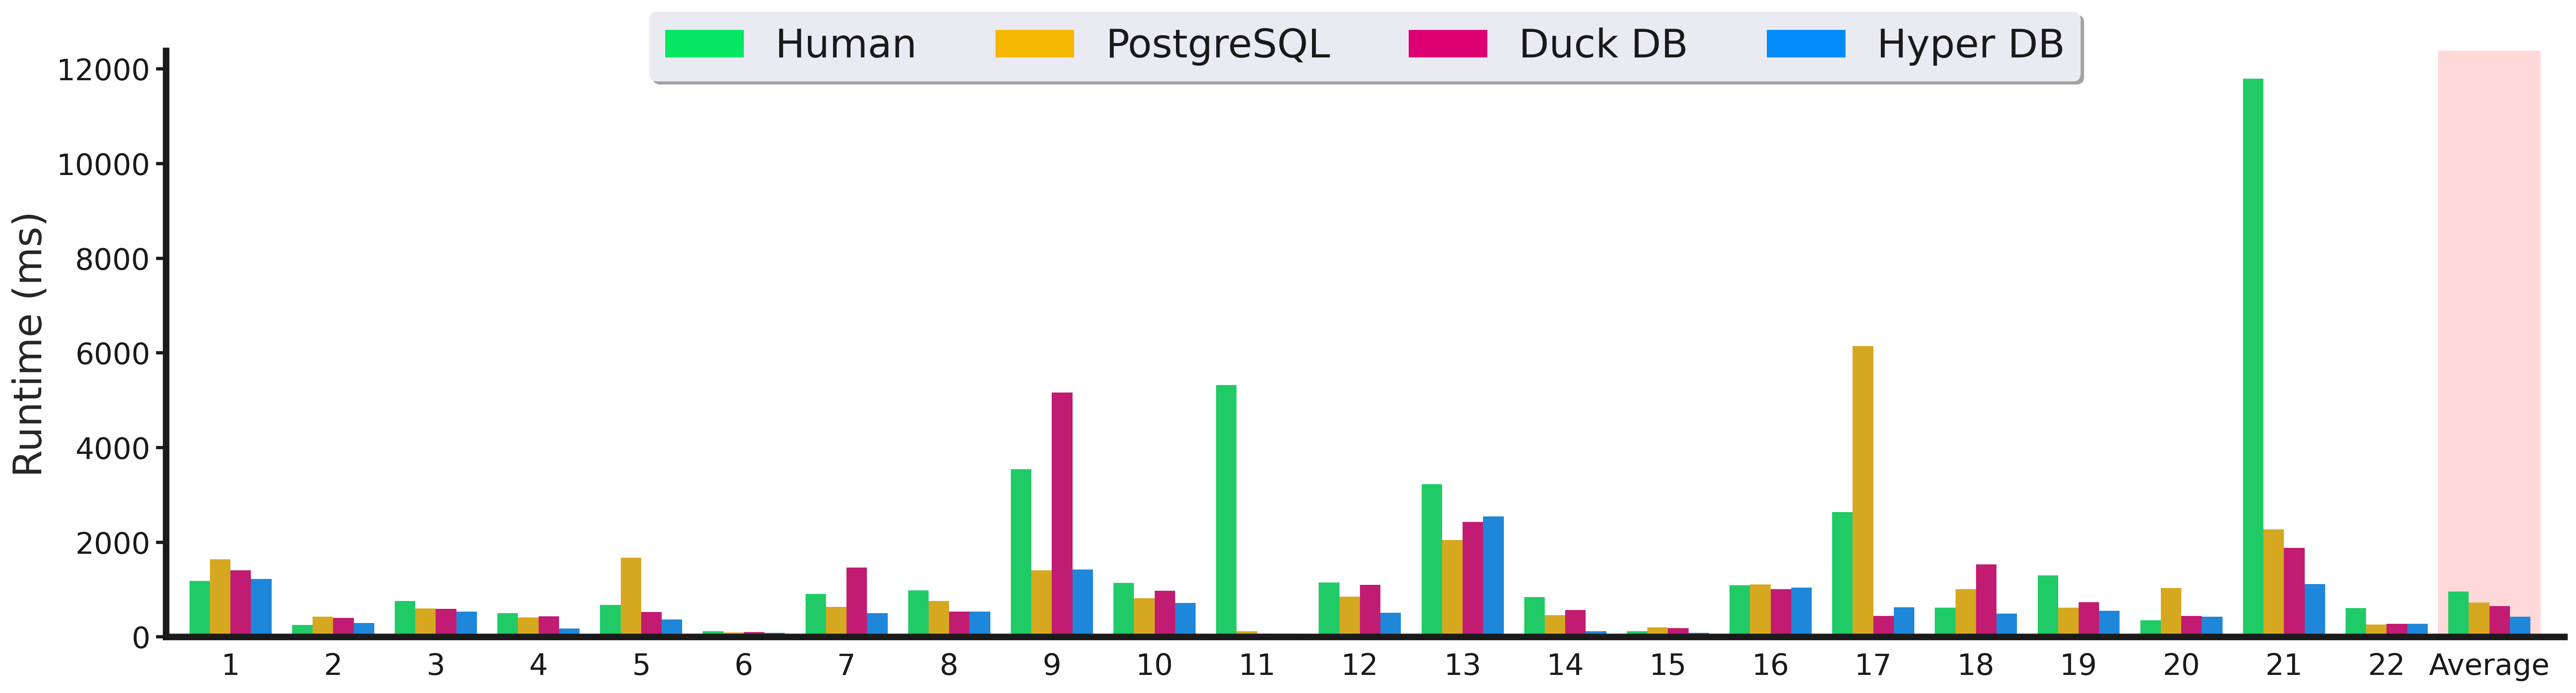

In [389]:
qp_color = ["#04e762", "#f5b700", "#dc0073", "#008bf8"]
make_graph(
    qp_data, qp_order, qp_color,
    "../analysis_results/cgo/qp_graph.pdf", 6, 22
    )

## Query Engine Figure

In [390]:
sdqlpy_pd_results =  pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_opt_all_comparison_test_results.csv") 
sdqlpy_pd_results = sdqlpy_pd_results[sdqlpy_pd_results["Data Type"].isin(["SDQLpy", "Pandas"])]
sdqlpy_pd_results['Query Name'] = sdqlpy_pd_results['Query Name'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas'
    }
)

hyper_results = pd.read_csv("../test_results/hyper_nlo_tpch_test_results.csv")
hyper_results = hyper_results[hyper_results["Query Name"] == "Hyper DB"]

qe_results = pd.concat([sdqlpy_pd_results, hyper_results], ignore_index=True)

In [391]:
qe_data = pre_process(qe_results).reset_index()

qe_data['Query Type'] = qe_data['Query Type'].replace(
    {
        'Naive SDQLpy': 'SDQL.py',
        'O1,O2,O3,O4 SDQLpy' : 'SDQL.py + OPT'
     }
)

qe_order = ["Pandas", 'SDQL.py', 'SDQL.py + OPT', 'Hyper DB']
qe_data = qe_data[qe_data["Query Type"].isin(qe_order)]

qe_data = qe_data.set_index('Query Type').loc[qe_order]
qe_data = qe_data.reset_index()

qe_data = qe_data.rename(columns={"Overall Mean Runtime (s)" : "Mean"})
# Convert to ms
qe_data['Mean'] = qe_data['Mean'].apply(lambda x : x * 1000)

The DataFrame has 88 rows
The DataFrame now has 92 rows


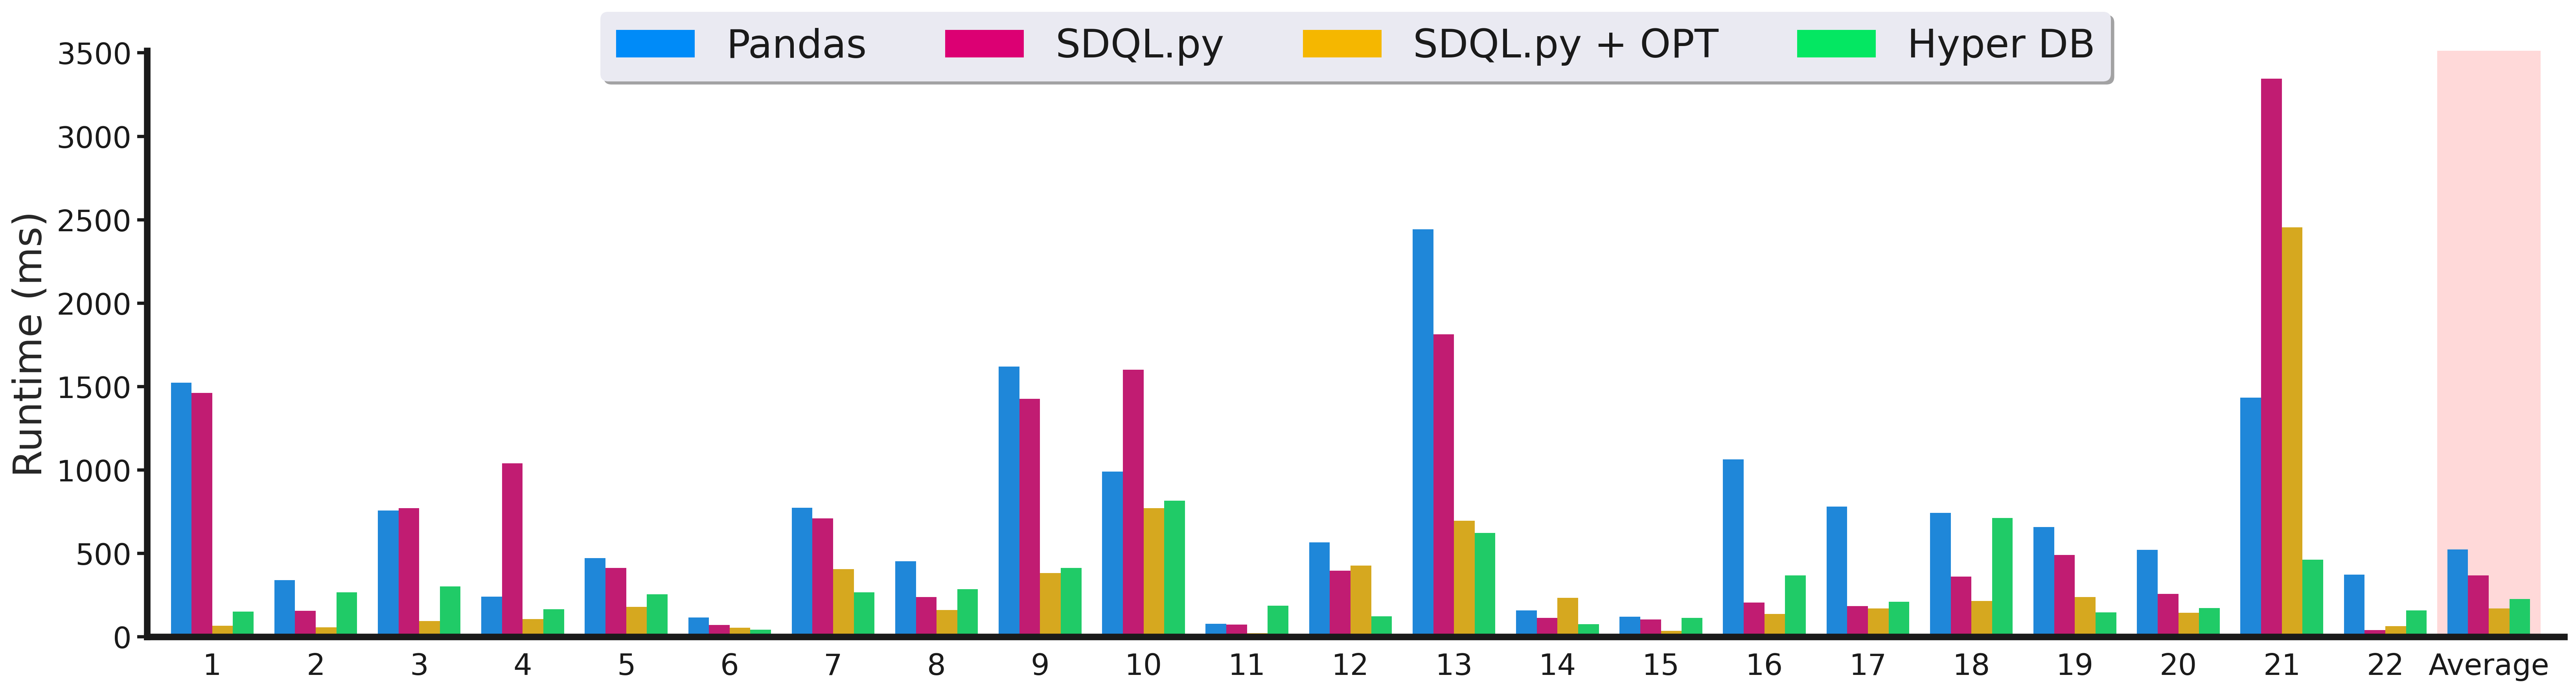

In [392]:
qe_color = ["#008bf8", "#dc0073", "#f5b700", "#04e762"]
make_graph(
    qe_data, qe_order, qe_color,
    "../analysis_results/cgo/qe_graph.pdf", 6, 22
    )